# NASA Turbofan Jet Engine - EDA (Exploratory Data Analysis)

## 프로젝트 개요
- **목표**: NASA 터보팬 제트 엔진의 잔존 수명(RUL) 예측 및 예지보전 방안 모색
- **데이터**: NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) 데이터셋

## EDA 구조
1. 데이터 불러오기
2. 전체 사이클 분포 분석
3. 센서별 드리프트/패턴 분석
4. 제거할 센서 리스트 확정
5. Rolling window 길이 확정

## 1. 라이브러리 Import 및 초기 설정

In [22]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# 시각화 설정
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


## 2. 데이터 불러오기

데이터 구조:
- **26개 컬럼**: unit number(1) + time(1) + operational settings(3) + sensor measurements(21)
- **FD001**: 100개 train, 100개 test (조건: 1개, 고장모드: HPC Degradation)
- **FD002**: 260개 train, 259개 test (조건: 6개, 고장모드: HPC Degradation)
- **FD003**: 100개 train, 100개 test (조건: 1개, 고장모드: HPC + Fan Degradation)
- **FD004**: 248개 train, 249개 test (조건: 6개, 고장모드: HPC + Fan Degradation)

In [23]:
# 데이터 경로 설정
data_path = Path('../CMaps')

# 컬럼명 정의
index_cols = ['unit_id', 'time_cycles']
op_settings = ['op_setting_1', 'op_setting_2', 'op_setting_3']
# NASA CMAPSS 실제 센서명 적용
sensor_cols = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
column_names = index_cols + op_settings + sensor_cols

print(f"총 컬럼 수: {len(column_names)}")
print(f"컬럼 구성: {column_names[:5]} ... {column_names[-3:]}")

총 컬럼 수: 26
컬럼 구성: ['unit_id', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] ... ['PCNfR_dmd', 'W31', 'W32']


In [24]:
def load_data(dataset_num):
    # 파일 경로
    train_file = data_path / f'train_FD00{dataset_num}.txt'
    test_file = data_path / f'test_FD00{dataset_num}.txt'
    rul_file = data_path / f'RUL_FD00{dataset_num}.txt'
    
    # 데이터 로드
    train_df = pd.read_csv(train_file, sep='\s+', header=None, names=column_names)
    test_df = pd.read_csv(test_file, sep='\s+', header=None, names=column_names)
    rul_df = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])
    
    print(f"FD00{dataset_num} 데이터 로드 완료")
    print(f"  - Train shape: {train_df.shape}")
    print(f"  - Test shape: {test_df.shape}")
    print(f"  - RUL shape: {rul_df.shape}")
    
    return train_df, test_df, rul_df

train_df, test_df, rul_df = load_data(3)

FD003 데이터 로드 완료
  - Train shape: (24720, 26)
  - Test shape: (16596, 26)
  - RUL shape: (100, 1)


In [25]:
# 데이터 기본 정보 확인
print("=" * 60)
print("Train 데이터 기본 정보")
print("=" * 60)
train_df.info()

Train 데이터 기본 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24720 entries, 0 to 24719
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit_id       24720 non-null  int64  
 1   time_cycles   24720 non-null  int64  
 2   op_setting_1  24720 non-null  float64
 3   op_setting_2  24720 non-null  float64
 4   op_setting_3  24720 non-null  float64
 5   T2            24720 non-null  float64
 6   T24           24720 non-null  float64
 7   T30           24720 non-null  float64
 8   T50           24720 non-null  float64
 9   P2            24720 non-null  float64
 10  P15           24720 non-null  float64
 11  P30           24720 non-null  float64
 12  Nf            24720 non-null  float64
 13  Nc            24720 non-null  float64
 14  epr           24720 non-null  float64
 15  Ps30          24720 non-null  float64
 16  phi           24720 non-null  float64
 17  NRf           24720 non-null  float64
 18  NRc       

In [26]:
train_df.head()

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [27]:
print("\n" + "=" * 60)
print("기술 통계량")
print("=" * 60)
train_df.describe()


기술 통계량


,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.0,24720.00,24720.000000,24720.000000,24720.000000,2.472000e+04,...,24720.000000,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.0,24720.0,24720.000000,24720.000000
mean,48.631877,139.077063,-0.000024,0.000005,100.0,518.67,642.457858,1588.079175,1404.471212,1.462000e+01,...,523.050873,2388.071643,8144.202916,8.396176,3.000000e-02,392.566545,2388.0,100.0,38.988552,23.393024
std,29.348985,98.846675,0.002194,0.000294,0.0,0.00,0.523031,6.810418,9.773178,3.552786e-15,...,3.255314,0.158121,16.504118,0.060512,1.734759e-17,1.761459,0.0,0.0,0.248865,0.149234
min,1.000000,1.000000,-0.008600,-0.000600,100.0,518.67,640.840000,1564.300000,1377.060000,1.462000e+01,...,517.770000,2386.930000,8099.680000,8.156300,3.000000e-02,388.000000,2388.0,100.0,38.170000,22.872600
25%,23.000000,62.000000,-0.001500,-0.000200,100.0,518.67,642.080000,1583.280000,1397.187500,1.462000e+01,...,521.150000,2388.010000,8134.510000,8.360600,3.000000e-02,391.000000,2388.0,100.0,38.830000,23.296200
50%,47.000000,124.000000,-0.000000,-0.000000,100.0,518.67,642.400000,1587.520000,1402.910000,1.462000e+01,...,521.980000,2388.070000,8141.200000,8.398300,3.000000e-02,392.000000,2388.0,100.0,38.990000,23.391600
75%,74.000000,191.000000,0.001500,0.000300,100.0,518.67,642.790000,1592.412500,1410.600000,1.462000e+01,...,523.840000,2388.140000,8149.230000,8.437000,3.000000e-02,394.000000,2388.0,100.0,39.140000,23.483300
max,100.000000,525.000000,0.008600,0.000700,100.0,518.67,645.110000,1615.390000,1441.160000,1.462000e+01,...,537.400000,2388.610000,8290.550000,8.570500,3.000000e-02,399.000000,2388.0,100.0,39.850000,23.950500


## 환경 조건 변수 분포 및 해석

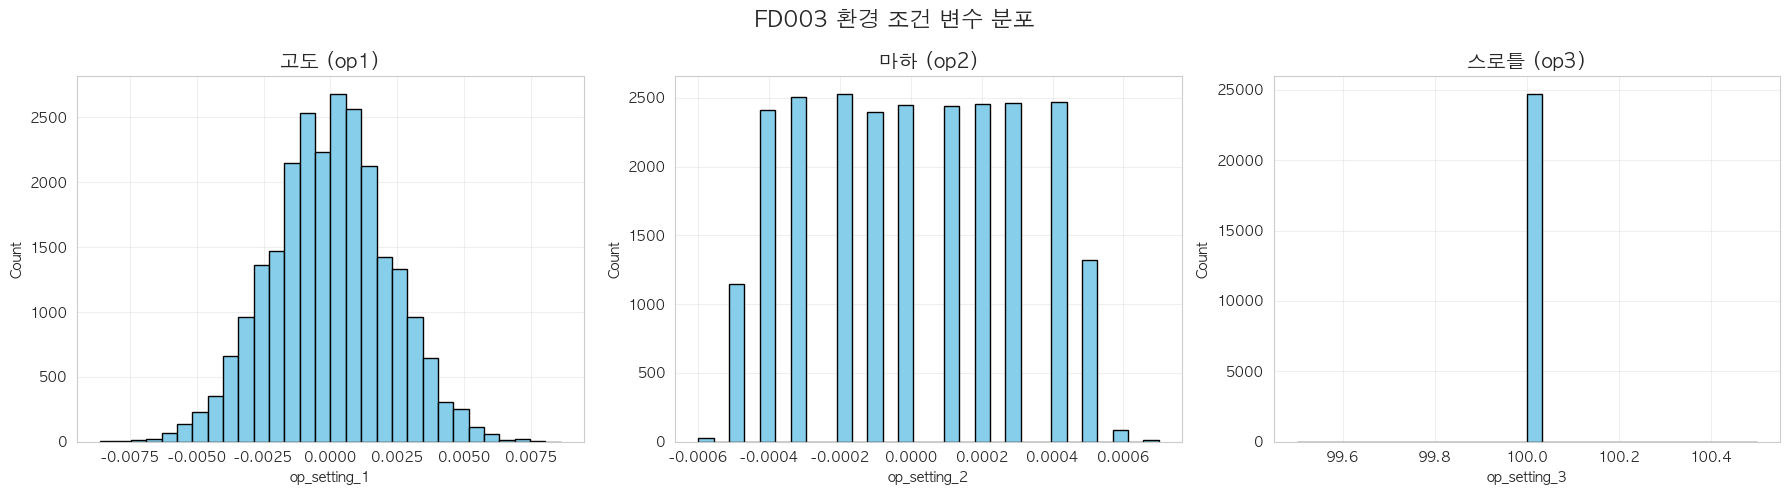

In [28]:
# 환경 조건 변수 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
env_vars = ['op_setting_1', 'op_setting_2', 'op_setting_3']
titles = ['고도 (op1)', '마하 (op2)', '스로틀 (op3)']
for i, var in enumerate(env_vars):
    axes[i].hist(train_df[var], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].grid(alpha=0.3)
plt.suptitle('FD003 환경 조건 변수 분포', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- op1(고도) : 정규분포  
0을 중심으로 정규분포의 형태를 가짐.  
특정 설정값을 기준으로 약간의 노이즈나 변동성만 갖는 연속형 변수를 의미  
--- 
- op2(마하) : 여러 가지 그룹  
여러 개의 뚜렷한 값으로 나뉘며, 범주형, 원-핫 인코딩 등  
여러가지 전처리 적용 방안을 세울 수 있음.  
---
- op3(스로틀) : 상수  
100.0의 단일값을 가지는 추력 조건  
분산이 0을 나타내는 변수이며, RUL 예측에 대한 정보를 제공하지 못함.  
---
FD003 데이터셋은 단일 조건으로  위 분포는 단일 운전 조건 하에서의 
미세한 변동(noise).


## 3. 전체 사이클 분포 분석

각 엔진의 전체 수명 사이클 수를 파악하고, RUL을 계산합니다.

In [29]:
# 각 엔진별 전체 사이클 수 계산
train_max_cycles = train_df.groupby('unit_id')['time_cycles'].max().reset_index()
train_max_cycles.columns = ['unit_id', 'max_cycles']

print("엔진별 전체 사이클 수 통계:")
print(train_max_cycles['max_cycles'].describe())
print(f"\n총 엔진 수: {train_max_cycles['unit_id'].nunique()}개")
print(f"평균 수명: {train_max_cycles['max_cycles'].mean():.2f} cycles")
print(f"최소 수명: {train_max_cycles['max_cycles'].min()} cycles")
print(f"최대 수명: {train_max_cycles['max_cycles'].max()} cycles")

엔진별 전체 사이클 수 통계:
count    100.00000
mean     247.20000
std       86.48384
min      145.00000
25%      189.75000
50%      220.50000
75%      279.75000
max      525.00000
Name: max_cycles, dtype: float64

총 엔진 수: 100개
평균 수명: 247.20 cycles
최소 수명: 145 cycles
최대 수명: 525 cycles


<FD003_unit1>

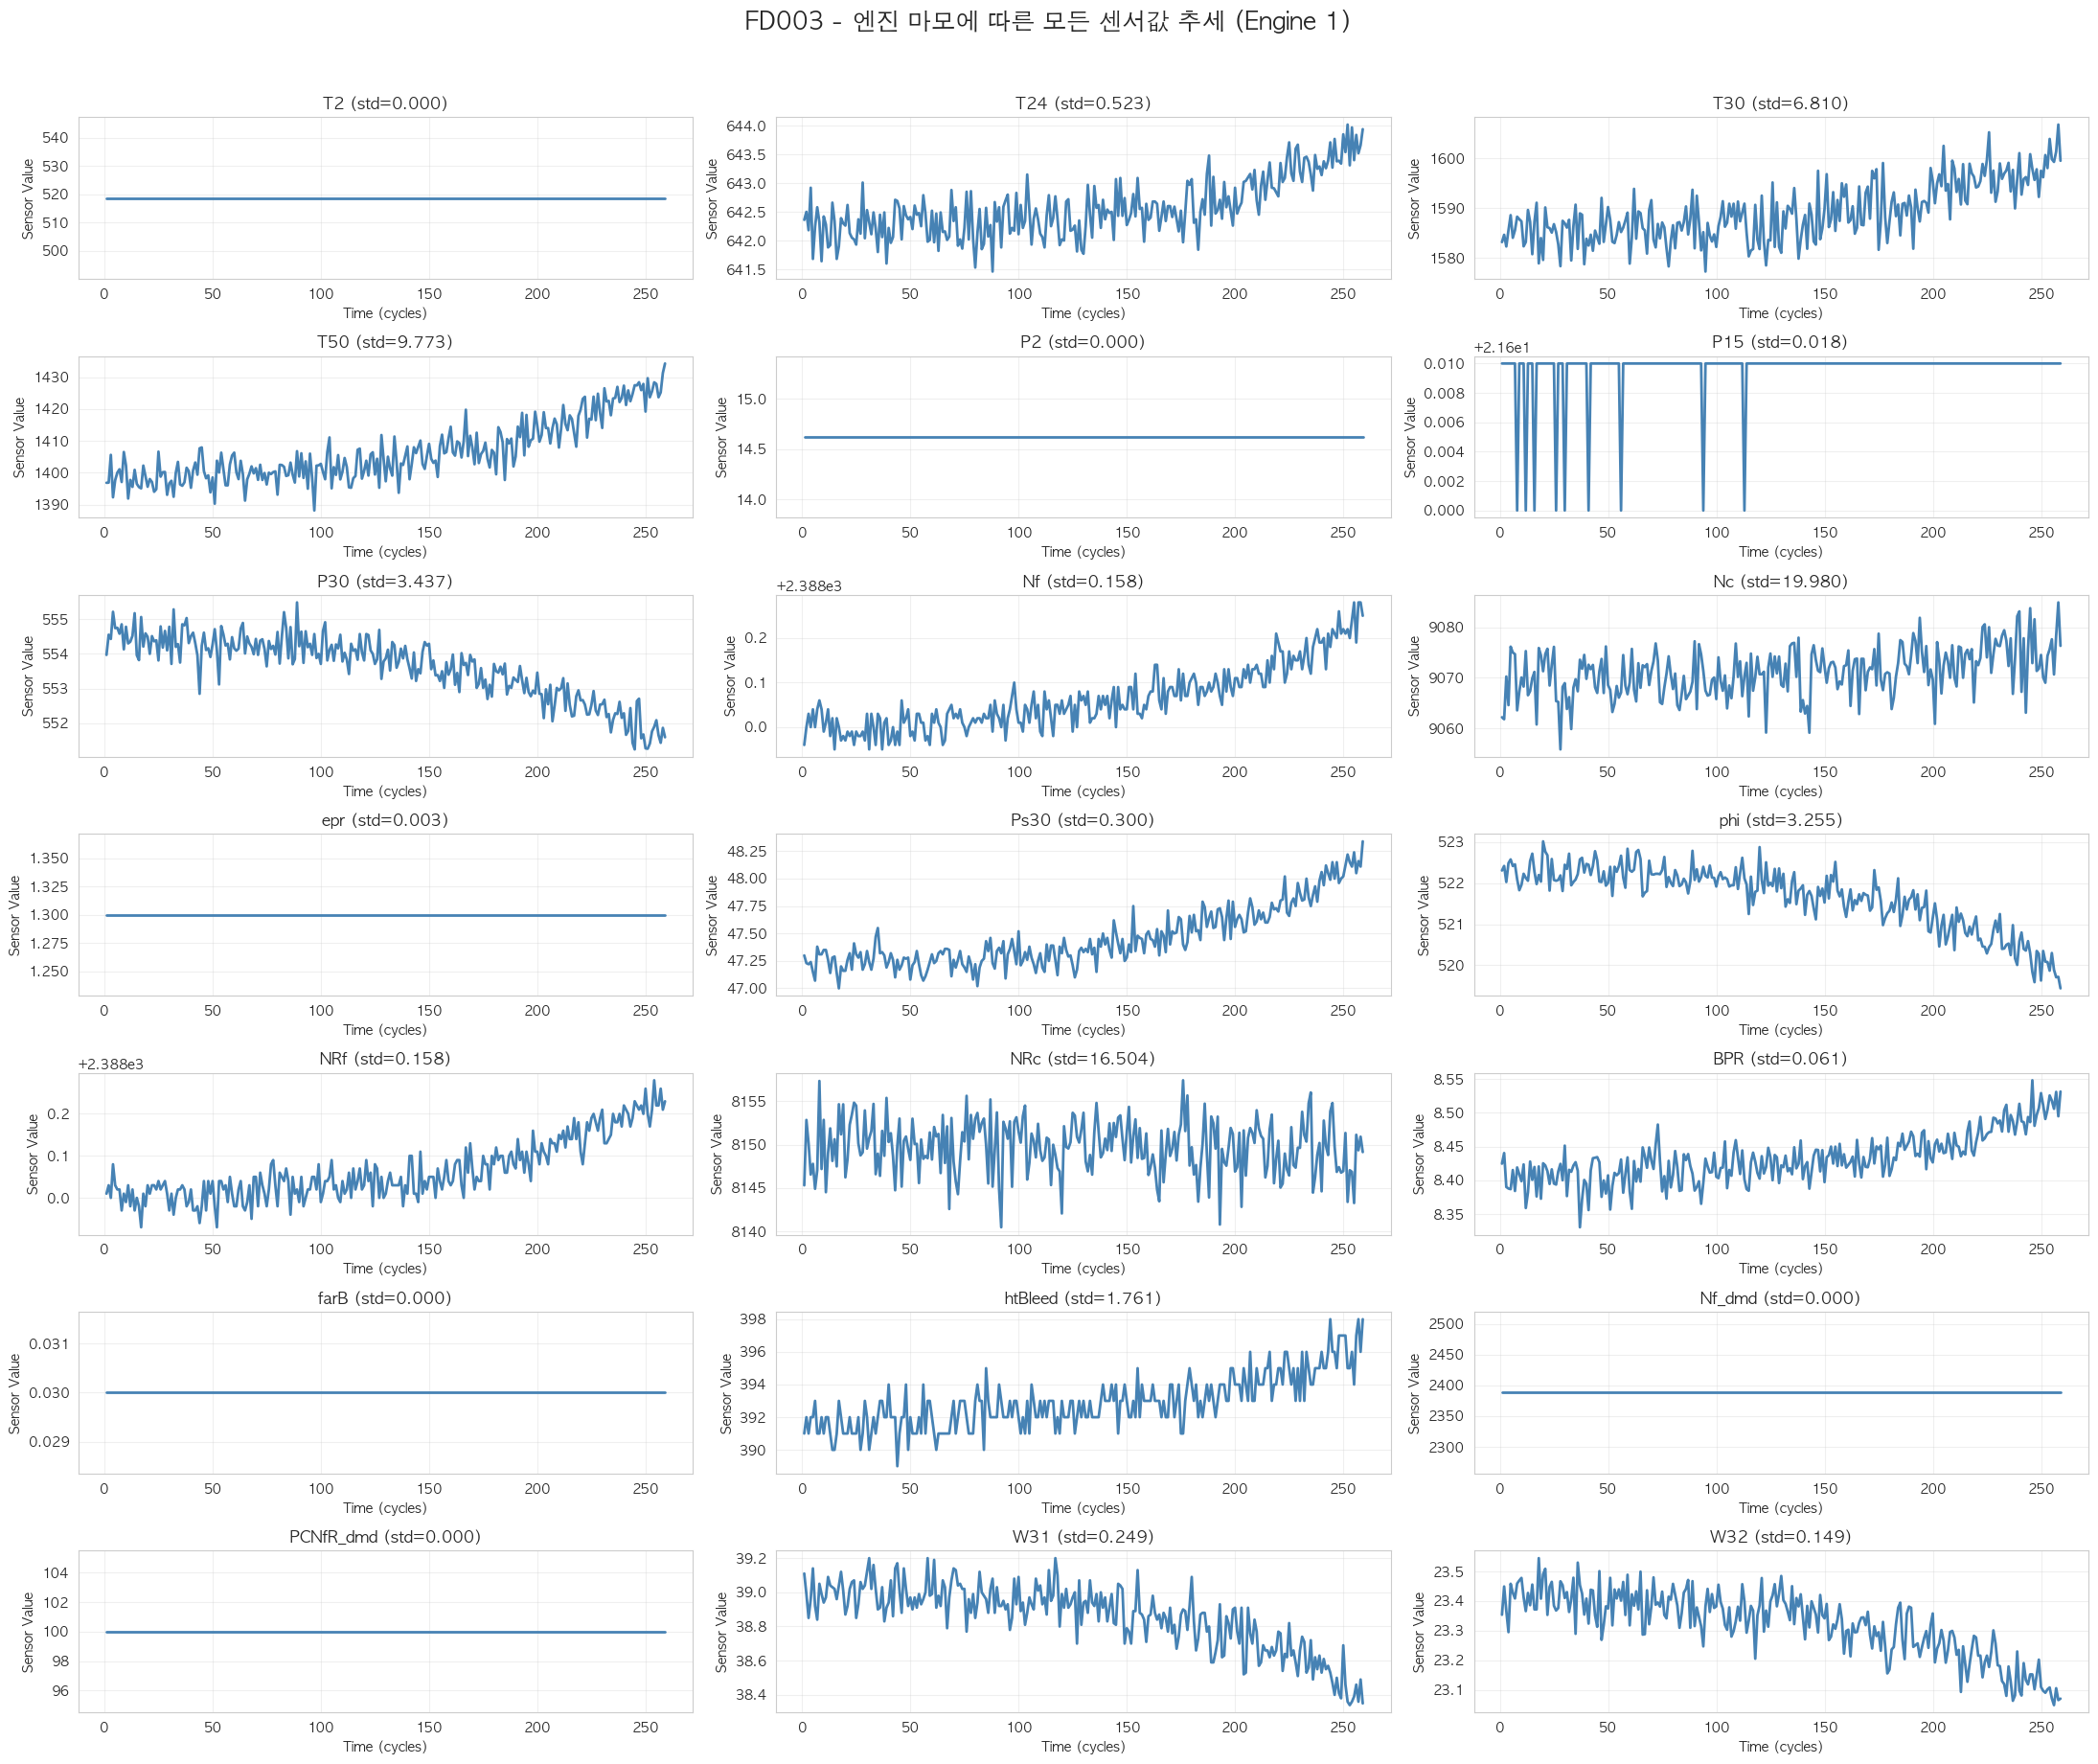

In [46]:
# 엔진 마모(사이클 진행)에 따른 모든 센서값 추세 시각화 (Engine 1, 21개 센서)
sample_engine = train_df[train_df['unit_id'] == 1].copy()
all_sensors = sensor_cols  # 21개 센서 모두
fig, axes = plt.subplots(7, 3, figsize=(22, 18))
axes = axes.ravel()
for idx, sensor in enumerate(all_sensors):
    axes[idx].plot(sample_engine['time_cycles'], sample_engine[sensor], color='steelblue', linewidth=2)
    axes[idx].set_title(f'{sensor} (std={sensor_stats.loc[sensor, "std"]:.3f})', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time (cycles)', fontsize=10)
    axes[idx].set_ylabel('Sensor Value', fontsize=10)
    axes[idx].grid(alpha=0.3)
# 빈 서브플롯 숨기기 (21개 이후)
for idx in range(len(all_sensors), len(axes)):
    axes[idx].axis('off')
plt.suptitle('FD003 - 엔진 마모에 따른 모든 센서값 추세 (Engine 1)', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

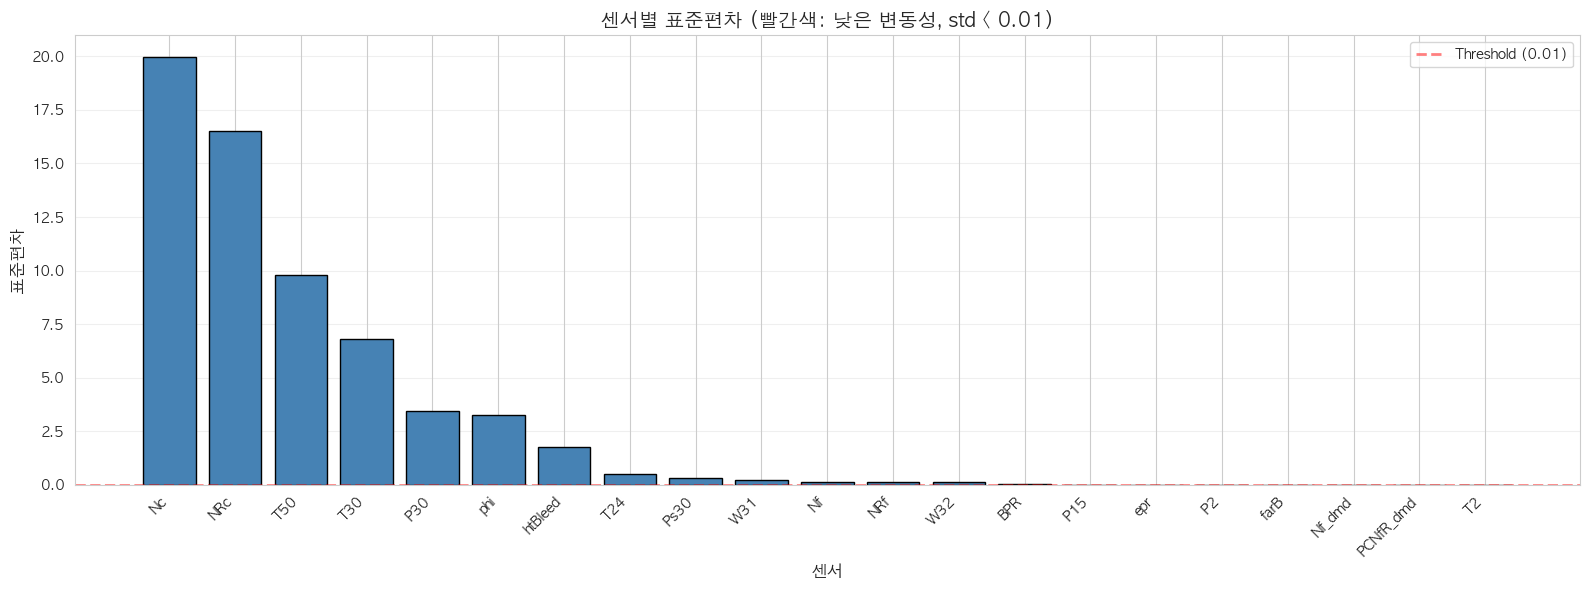

In [47]:
# 센서별 표준편차 시각화
fig, ax = plt.subplots(figsize=(16, 6))

sensor_stats_sorted = sensor_stats.sort_values('std', ascending=False)
colors = ['red' if x < 0.01 else 'steelblue' for x in sensor_stats_sorted['std']]

ax.bar(range(len(sensor_stats_sorted)), sensor_stats_sorted['std'], color=colors, edgecolor='black')
ax.set_xticks(range(len(sensor_stats_sorted)))
ax.set_xticklabels(sensor_stats_sorted.index, rotation=45, ha='right')
ax.set_xlabel('센서', fontsize=12)
ax.set_ylabel('표준편차', fontsize=12)
ax.set_title('센서별 표준편차 (빨간색: 낮은 변동성, std < 0.01)', fontsize=14, fontweight='bold')
ax.axhline(y=0.01, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Threshold (0.01)')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [32]:
# RUL(Remaining Useful Life) 계산 함수
def add_rul(df):
    df = df.copy()
    # 각 엔진별 최대 사이클 계산
    max_cycles = df.groupby('unit_id')['time_cycles'].max().reset_index()
    max_cycles.columns = ['unit_id', 'max_cycles']
    
    # 원본 데이터와 병합
    df = df.merge(max_cycles, on='unit_id', how='left')
    
    # RUL 계산: 전체 수명 - 현재 사이클
    df['RUL'] = df['max_cycles'] - df['time_cycles']
    
    # max_cycles 컬럼 제거
    df = df.drop('max_cycles', axis=1)
    
    return df

# Train 데이터에 RUL 추가
train_df = add_rul(train_df)

print("RUL 추가 완료!")
print(f"\nTrain 데이터 shape: {train_df.shape}")
print(f"\nRUL 통계:")
print(train_df['RUL'].describe())

RUL 추가 완료!

Train 데이터 shape: (24720, 27)

RUL 통계:
count    24720.000000
mean       138.077063
std         98.846675
min          0.000000
25%         61.000000
50%        123.000000
75%        190.000000
max        524.000000
Name: RUL, dtype: float64


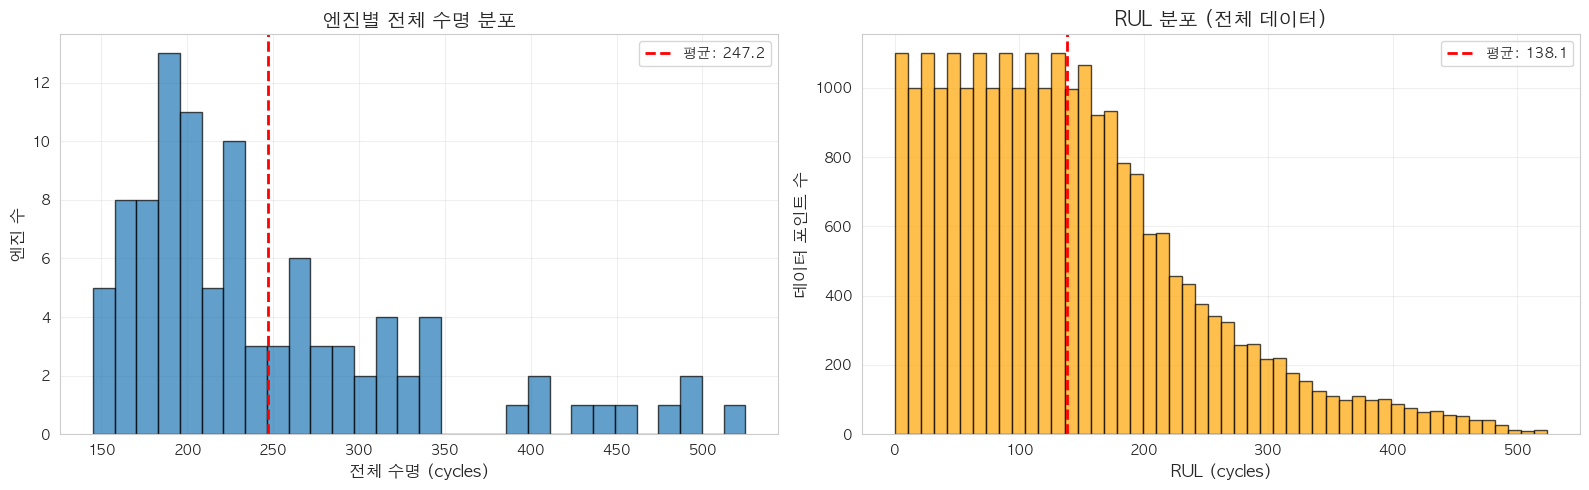

In [33]:
# 사이클 수 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. 엔진별 전체 사이클 수 히스토그램
axes[0].hist(train_max_cycles['max_cycles'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(train_max_cycles['max_cycles'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"평균: {train_max_cycles['max_cycles'].mean():.1f}")
axes[0].set_xlabel('전체 수명 (cycles)', fontsize=12)
axes[0].set_ylabel('엔진 수', fontsize=12)
axes[0].set_title('엔진별 전체 수명 분포', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. RUL 분포
axes[1].hist(train_df['RUL'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(train_df['RUL'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"평균: {train_df['RUL'].mean():.1f}")
axes[1].set_xlabel('RUL (cycles)', fontsize=12)
axes[1].set_ylabel('데이터 포인트 수', fontsize=12)
axes[1].set_title('RUL 분포 (전체 데이터)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

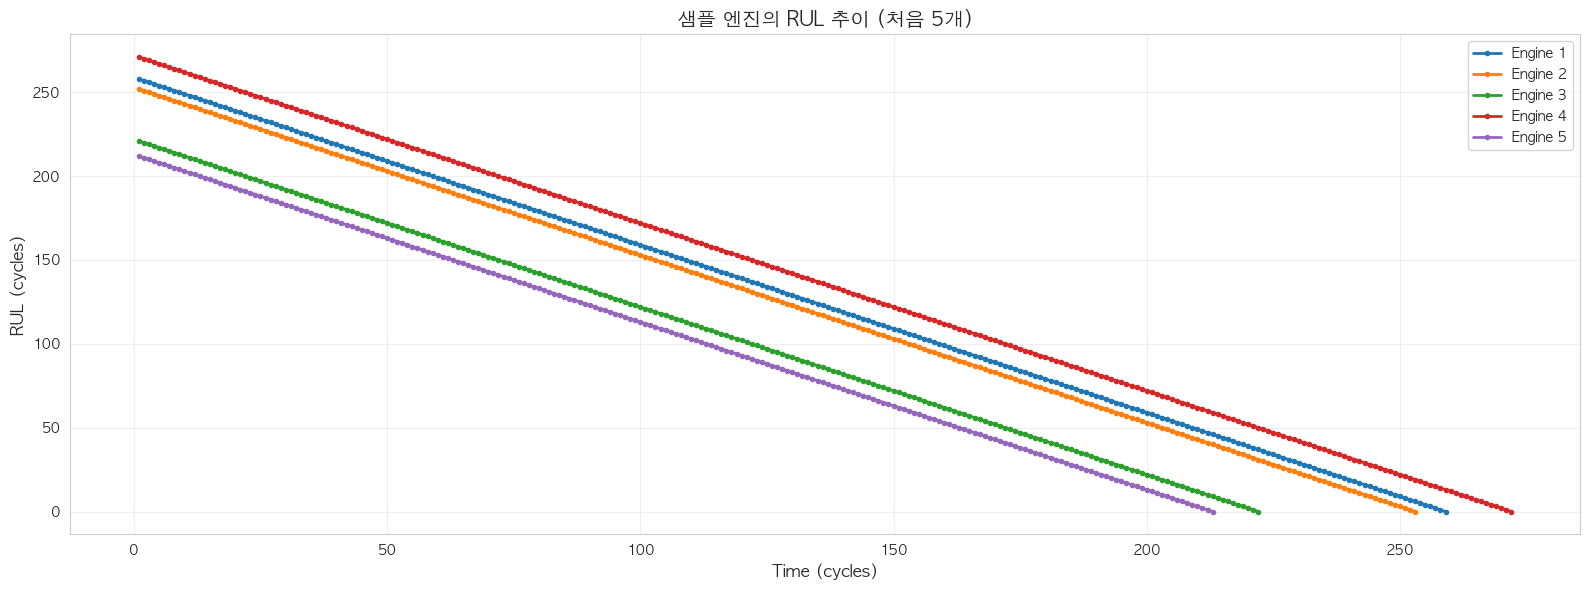

In [34]:
# 샘플 엔진의 수명 곡선 시각화 (처음 5개 엔진)
fig, ax = plt.subplots(figsize=(16, 6))

sample_units = train_df['unit_id'].unique()[:5]
for unit in sample_units:
    unit_data = train_df[train_df['unit_id'] == unit]
    ax.plot(unit_data['time_cycles'], unit_data['RUL'], 
            marker='o', markersize=3, label=f'Engine {unit}', linewidth=2)

ax.set_xlabel('Time (cycles)', fontsize=12)
ax.set_ylabel('RUL (cycles)', fontsize=12)
ax.set_title('샘플 엔진의 RUL 추이 (처음 5개)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. 센서별 드리프트/패턴 분석

21개 센서 데이터의 특성을 분석합니다:
- 시간에 따른 변화 패턴
- 분산 및 변동성
- RUL과의 상관관계

In [35]:
# 센서 데이터 분산 분석
sensor_stats = pd.DataFrame()
sensor_stats['std'] = train_df[sensor_cols].std()
sensor_stats['variance'] = train_df[sensor_cols].var()
sensor_stats['mean'] = train_df[sensor_cols].mean()
sensor_stats['min'] = train_df[sensor_cols].min()
sensor_stats['max'] = train_df[sensor_cols].max()
sensor_stats['range'] = sensor_stats['max'] - sensor_stats['min']

# 변동성이 거의 없는 센서 식별 (표준편차 < 0.01)
low_variance_sensors = sensor_stats[sensor_stats['std'] < 0.01].index.tolist()

print("센서별 통계:")
print(sensor_stats.sort_values('std', ascending=False))


센서별 통계:
                    std      variance         mean        min        max  \
Nc         1.998029e+01  3.992122e+02  9064.110809  9017.9800  9234.3500   
NRc        1.650412e+01  2.723859e+02  8144.202916  8099.6800  8290.5500   
T50        9.773178e+00  9.551501e+01  1404.471212  1377.0600  1441.1600   
T30        6.810418e+00  4.638179e+01  1588.079175  1564.3000  1615.3900   
P30        3.437343e+00  1.181533e+01   555.143808   549.6100   570.4900   
phi        3.255314e+00  1.059707e+01   523.050873   517.7700   537.4000   
htBleed    1.761459e+00  3.102736e+00   392.566545   388.0000   399.0000   
T24        5.230311e-01  2.735616e-01   642.457858   640.8400   645.1100   
Ps30       3.000742e-01  9.004450e-02    47.415707    46.6900    48.4400   
W31        2.488647e-01  6.193364e-02    38.988552    38.1700    39.8500   
Nf         1.582849e-01  2.505412e-02  2388.071555  2386.9000  2388.6000   
NRf        1.581207e-01  2.500215e-02  2388.071643  2386.9300  2388.6100   
W32 

In [36]:
print(f"\n낮은 변동성 센서 (std < 0.01): {low_variance_sensors}")


낮은 변동성 센서 (std < 0.01): ['T2', 'P2', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']


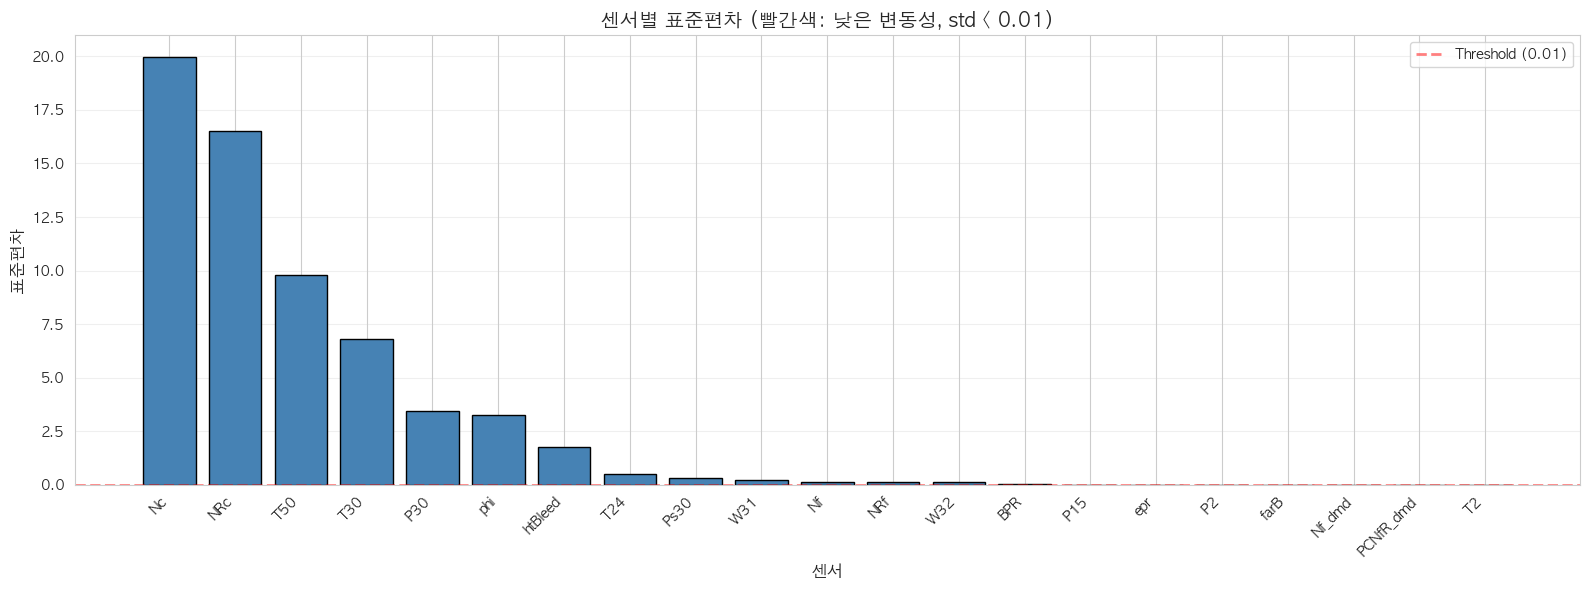

In [37]:
# 센서별 표준편차 시각화
fig, ax = plt.subplots(figsize=(16, 6))

sensor_stats_sorted = sensor_stats.sort_values('std', ascending=False)
colors = ['red' if x < 0.01 else 'steelblue' for x in sensor_stats_sorted['std']]

ax.bar(range(len(sensor_stats_sorted)), sensor_stats_sorted['std'], color=colors, edgecolor='black')
ax.set_xticks(range(len(sensor_stats_sorted)))
ax.set_xticklabels(sensor_stats_sorted.index, rotation=45, ha='right')
ax.set_xlabel('센서', fontsize=12)
ax.set_ylabel('표준편차', fontsize=12)
ax.set_title('센서별 표준편차 (빨간색: 낮은 변동성, std < 0.01)', fontsize=14, fontweight='bold')
ax.axhline(y=0.01, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Threshold (0.01)')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

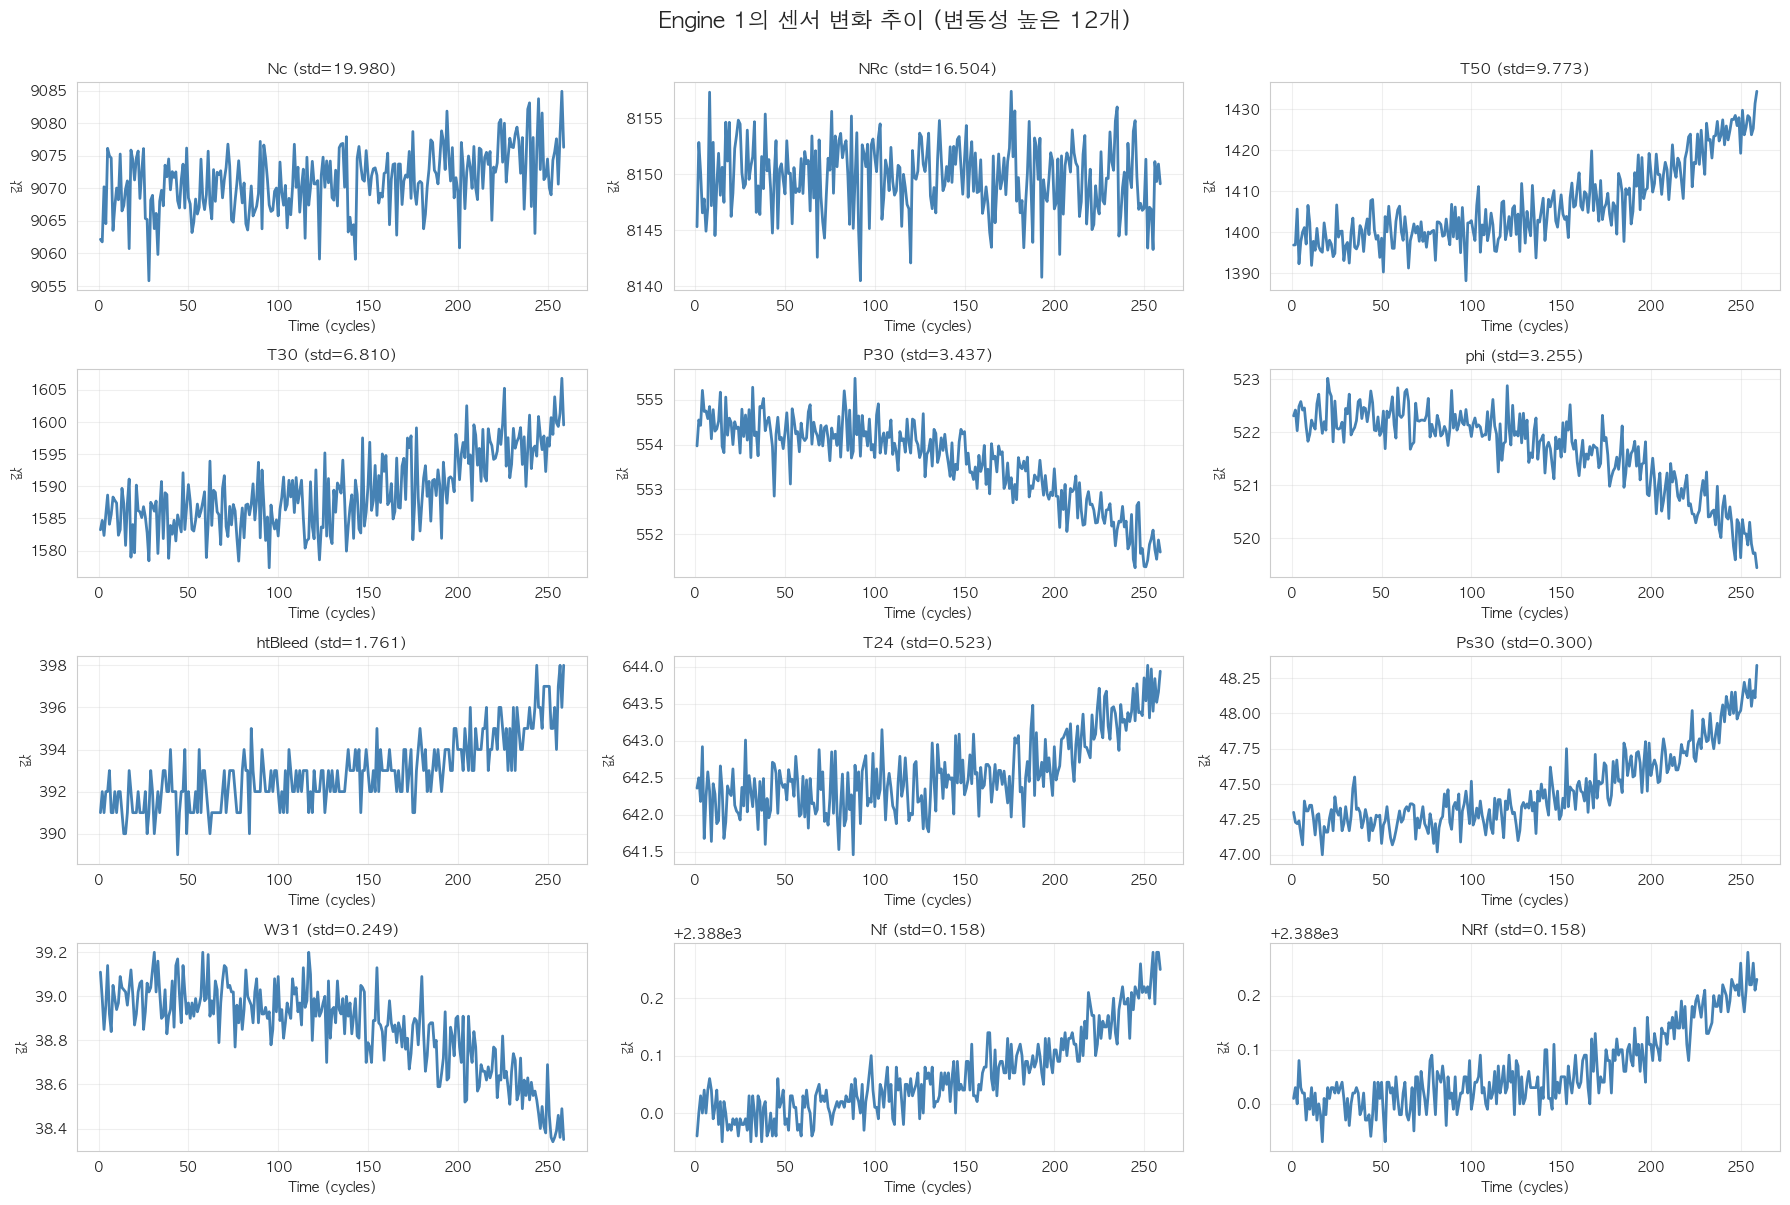

In [38]:
# 샘플 엔진(unit_id=1)의 센서 추이 시각화
sample_engine = train_df[train_df['unit_id'] == 1].copy()

# 변동성이 높은 상위 12개 센서 선택
top_sensors = sensor_stats.nlargest(12, 'std').index.tolist()

fig, axes = plt.subplots(4, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, sensor in enumerate(top_sensors):
    axes[idx].plot(sample_engine['time_cycles'], sample_engine[sensor], 
                   linewidth=2, color='steelblue')
    axes[idx].set_xlabel('Time (cycles)', fontsize=10)
    axes[idx].set_ylabel('값', fontsize=10)
    axes[idx].set_title(f'{sensor} (std={sensor_stats.loc[sensor, "std"]:.3f})', 
                        fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.suptitle('Engine 1의 센서 변화 추이 (변동성 높은 12개)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

RUL과의 상관계수 (절대값 기준 상위 10개):
Ps30       0.688915
T50        0.657224
NRf        0.656340
Nf         0.655345
htBleed    0.649220
T30        0.624236
T24        0.590564
Nc         0.551843
NRc        0.481807
epr        0.363432
Name: RUL, dtype: float64


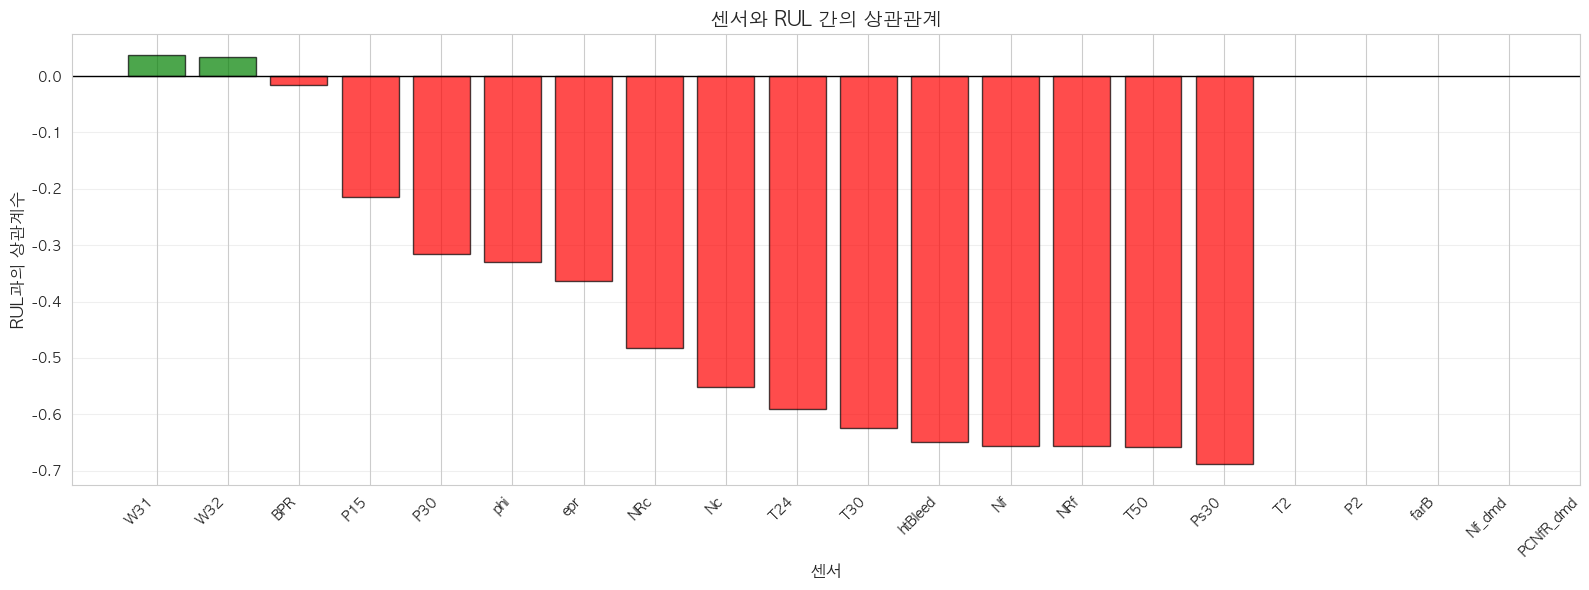

In [39]:
# RUL과 센서 간의 상관관계 분석
correlation_with_rul = train_df[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

print("RUL과의 상관계수 (절대값 기준 상위 10개):")
print(correlation_with_rul.abs().sort_values(ascending=False).head(10))

# 상관계수 시각화
fig, ax = plt.subplots(figsize=(16, 6))

colors = ['green' if x > 0 else 'red' for x in correlation_with_rul.values]
ax.bar(range(len(correlation_with_rul)), correlation_with_rul.values, 
       color=colors, edgecolor='black', alpha=0.7)
ax.set_xticks(range(len(correlation_with_rul)))
ax.set_xticklabels(correlation_with_rul.index, rotation=45, ha='right')
ax.set_xlabel('센서', fontsize=12)
ax.set_ylabel('RUL과의 상관계수', fontsize=12)
ax.set_title('센서와 RUL 간의 상관관계', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 5. 제거할 센서 리스트 확정

제거 기준:
1. **낮은 변동성**: 표준편차 < 0.01 (거의 상수값)
2. **낮은 상관성**: |상관계수| < 0.1 (RUL과의 관계가 약함)

In [40]:
# 제거할 센서 식별
std_threshold = 0.01
corr_threshold = 0.1

# 1. 낮은 변동성 센서
low_variance = sensor_stats[sensor_stats['std'] < std_threshold].index.tolist()

# 2. 낮은 상관성 센서
low_correlation = correlation_with_rul[abs(correlation_with_rul) < corr_threshold].index.tolist()

# 합집합 (둘 중 하나라도 해당되면 제거 후보)
sensors_to_remove = list(set(low_variance + low_correlation))
sensors_to_remove.sort()

# 유지할 센서
sensors_to_keep = [s for s in sensor_cols if s not in sensors_to_remove]

print("=" * 60)
print("센서 제거 분석 결과")
print("=" * 60)
print(f"\n1. 낮은 변동성 센서 (std < {std_threshold}):")
print(f"   {low_variance}")
print(f"\n2. 낮은 상관성 센서 (|corr| < {corr_threshold}):")
print(f"   {low_correlation}")
print(f"\n제거할 센서 (총 {len(sensors_to_remove)}개):")
print(f"   {sensors_to_remove}")
print(f"\n유지할 센서 (총 {len(sensors_to_keep)}개):")
print(f"   {sensors_to_keep}")

# 제거 상세 정보
print("\n" + "=" * 60)
print("제거 센서 상세 정보")
print("=" * 60)
removal_info = pd.DataFrame({
    'sensor': sensors_to_remove,
    'std': [sensor_stats.loc[s, 'std'] for s in sensors_to_remove],
    'corr_with_RUL': [correlation_with_rul.loc[s] for s in sensors_to_remove],
    'reason': ['Low Variance' if s in low_variance else 'Low Correlation' 
               for s in sensors_to_remove]
})
print(removal_info.to_string(index=False))

센서 제거 분석 결과

1. 낮은 변동성 센서 (std < 0.01):
   ['T2', 'P2', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']

2. 낮은 상관성 센서 (|corr| < 0.1):
   ['W31', 'W32', 'BPR']

제거할 센서 (총 9개):
   ['BPR', 'Nf_dmd', 'P2', 'PCNfR_dmd', 'T2', 'W31', 'W32', 'epr', 'farB']

유지할 센서 (총 12개):
   ['T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'htBleed']

제거 센서 상세 정보
   sensor          std  corr_with_RUL          reason
      BPR 6.051161e-02      -0.016501 Low Correlation
   Nf_dmd 0.000000e+00            NaN    Low Variance
       P2 3.552786e-15            NaN    Low Variance
PCNfR_dmd 0.000000e+00            NaN    Low Variance
       T2 0.000000e+00            NaN    Low Variance
      W31 2.488647e-01       0.037782 Low Correlation
      W32 1.492338e-01       0.033465 Low Correlation
      epr 3.484849e-03      -0.363432    Low Variance
     farB 1.734759e-17            NaN    Low Variance


## 6. Rolling Window 길이 확정

시계열 특성을 반영하기 위한 Rolling Window 기법 적용:
- 각 시점의 센서 값을 과거 N개 사이클의 통계로 변환
- 노이즈 감소 및 트렌드 파악에 유용
- Window 크기에 따른 성능 비교 필요

In [41]:
# Rolling Window 테스트 함수
def apply_rolling_window(df, window_size, sensor_list):

    df_rolled = df.copy()
    
    for sensor in sensor_list:
        # Rolling Mean
        df_rolled[f'{sensor}_rolling_mean'] = df_rolled.groupby('unit_id')[sensor].transform(
            lambda x: x.rolling(window=window_size, min_periods=1).mean()
        )
        # Rolling Std
        df_rolled[f'{sensor}_rolling_std'] = df_rolled.groupby('unit_id')[sensor].transform(
            lambda x: x.rolling(window=window_size, min_periods=1).std()
        )
    
    return df_rolled

# 테스트: 여러 window 크기 비교
window_sizes = [5, 10, 15, 20, 30]
sample_sensor = sensors_to_keep[0]  # 첫 번째 유효 센서로 테스트

print(f"테스트 센서: {sample_sensor}")
print(f"테스트 윈도우 크기: {window_sizes}")

테스트 센서: T24
테스트 윈도우 크기: [5, 10, 15, 20, 30]


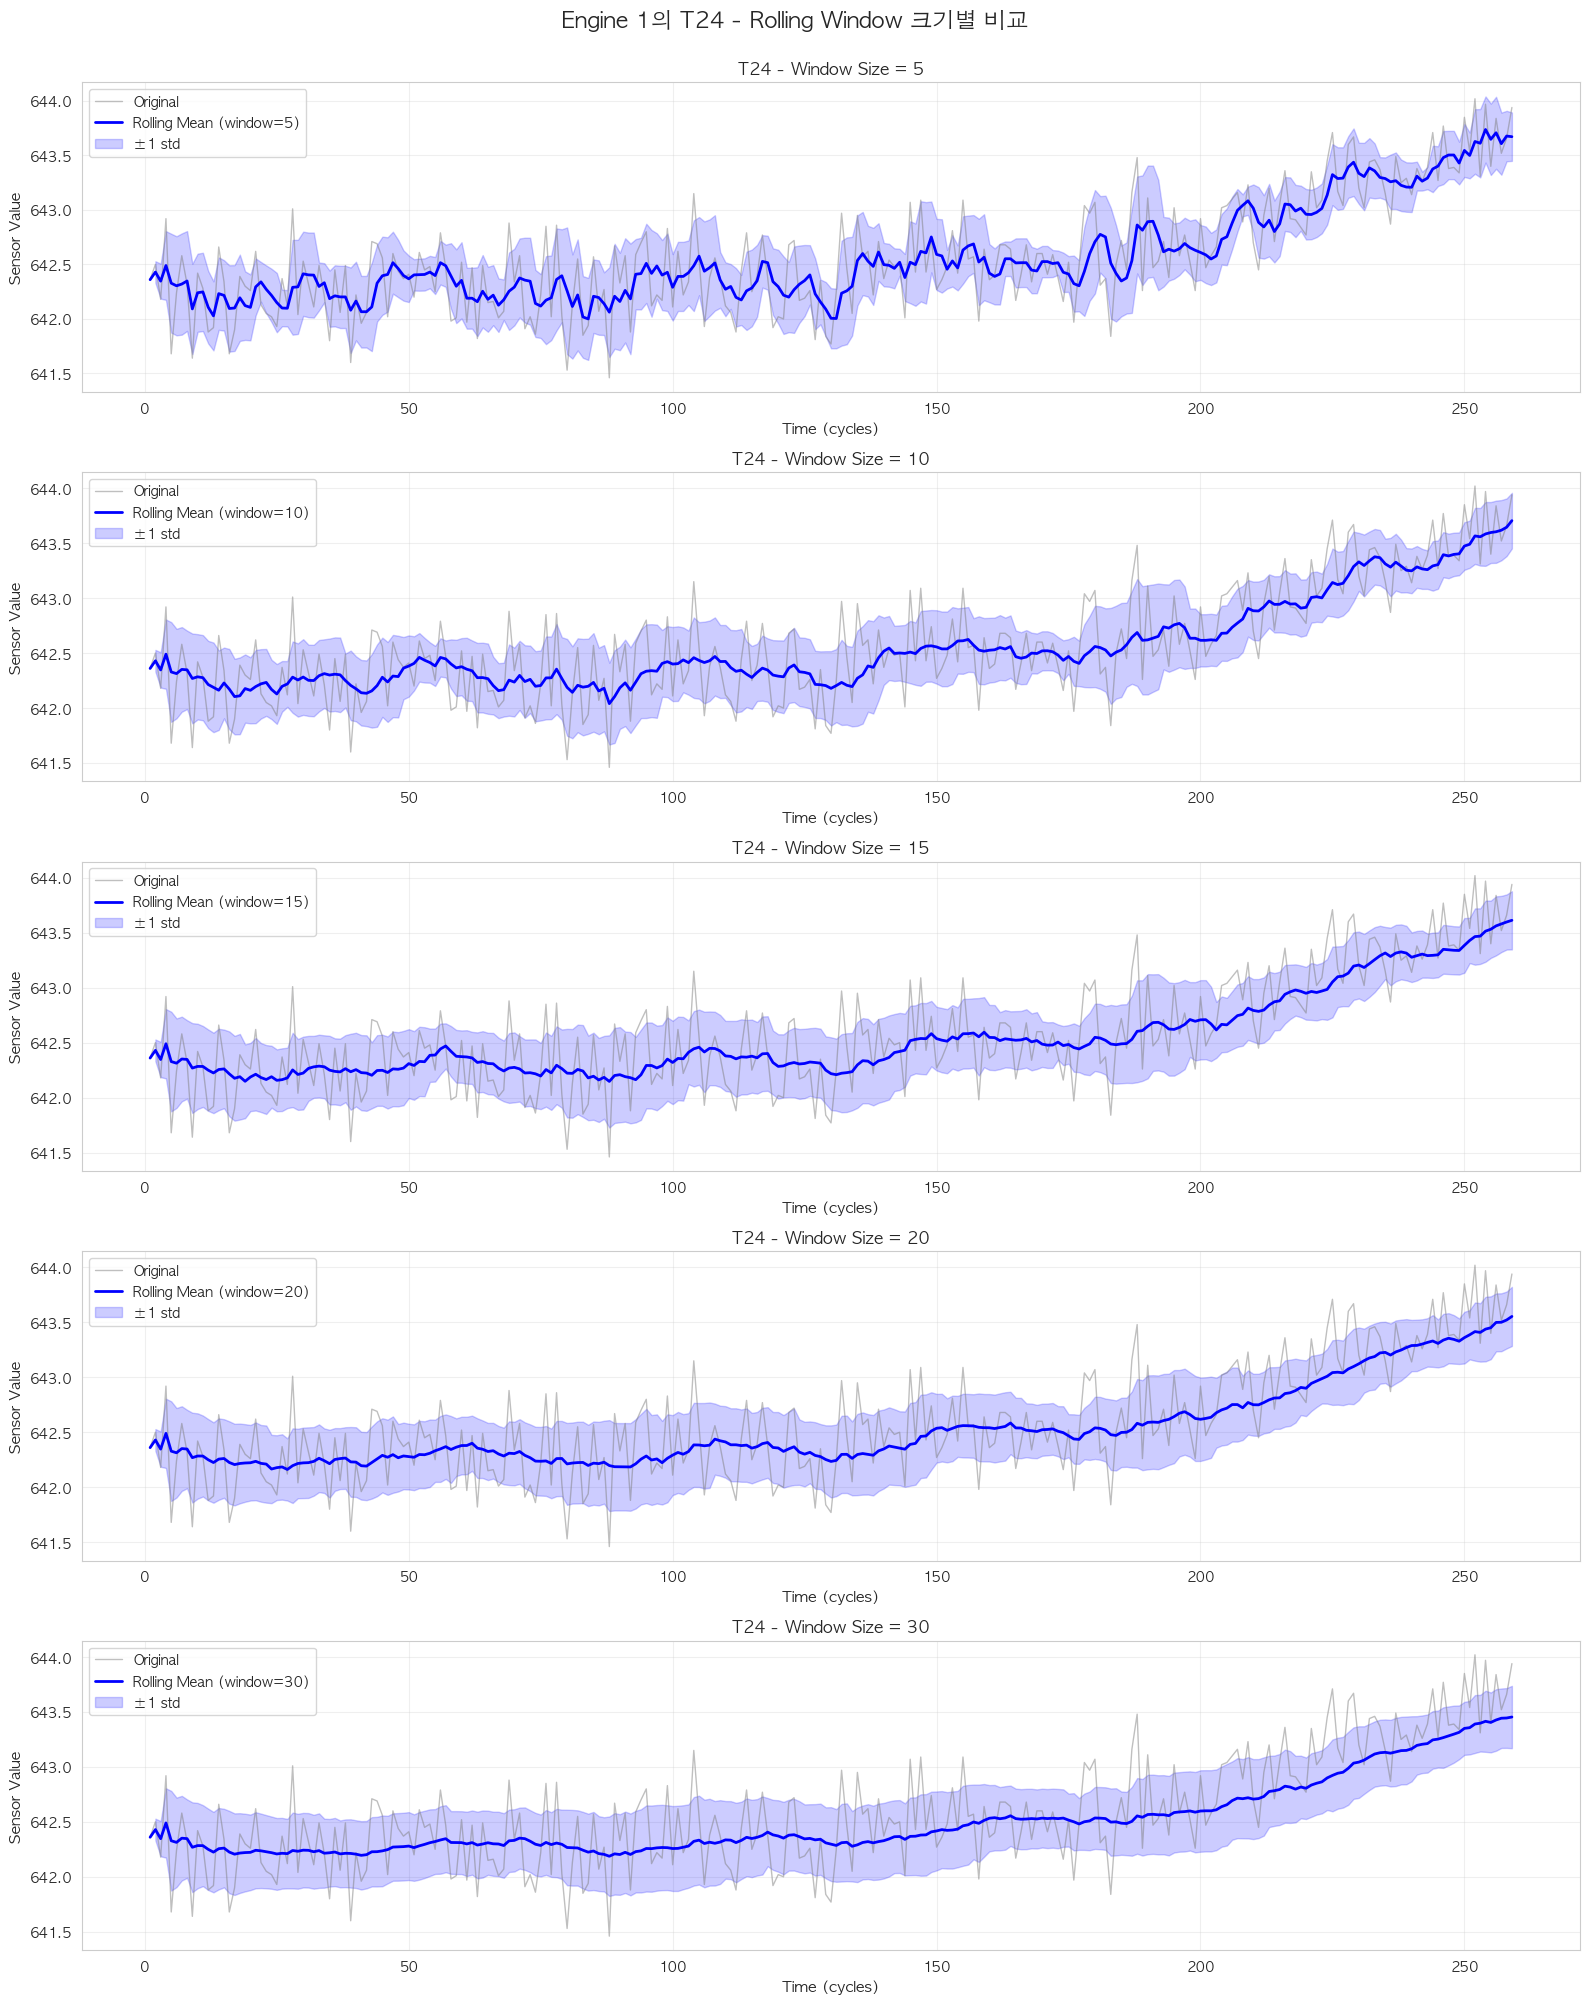

In [42]:
# 샘플 엔진으로 Window 크기별 효과 시각화
sample_unit_data = train_df[train_df['unit_id'] == 1].copy()

fig, axes = plt.subplots(len(window_sizes), 1, figsize=(16, 4*len(window_sizes)))

for idx, window in enumerate(window_sizes):
    # Rolling mean 계산
    rolling_mean = sample_unit_data[sample_sensor].rolling(window=window, min_periods=1).mean()
    rolling_std = sample_unit_data[sample_sensor].rolling(window=window, min_periods=1).std()
    
    # 시각화
    axes[idx].plot(sample_unit_data['time_cycles'], sample_unit_data[sample_sensor], 
                   label='Original', alpha=0.5, linewidth=1, color='gray')
    axes[idx].plot(sample_unit_data['time_cycles'], rolling_mean, 
                   label=f'Rolling Mean (window={window})', linewidth=2, color='blue')
    axes[idx].fill_between(sample_unit_data['time_cycles'], 
                           rolling_mean - rolling_std, 
                           rolling_mean + rolling_std, 
                           alpha=0.2, color='blue', label='±1 std')
    
    axes[idx].set_xlabel('Time (cycles)', fontsize=11)
    axes[idx].set_ylabel('Sensor Value', fontsize=11)
    axes[idx].set_title(f'{sample_sensor} - Window Size = {window}', 
                        fontsize=12, fontweight='bold')
    axes[idx].legend(loc='best')
    axes[idx].grid(alpha=0.3)

plt.suptitle(f'Engine 1의 {sample_sensor} - Rolling Window 크기별 비교', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [43]:
# Window 크기별 데이터 손실률 분석
print("=" * 60)
print("Rolling Window 크기별 분석")
print("=" * 60)

for window in window_sizes:
    # 각 엔진에서 window 크기보다 작은 데이터 포인트 비율
    total_points = len(train_df)
    lost_info_points = len(train_df[train_df.groupby('unit_id')['time_cycles'].transform('count') < window])
    
    # 평균 사이클 대비 비율
    avg_cycles = train_max_cycles['max_cycles'].mean()
    window_pct = (window / avg_cycles) * 100
    
    print(f"\nWindow Size: {window}")
    print(f"  - 평균 수명 대비 비율: {window_pct:.2f}%")
    print(f"  - 초기 {window} 사이클의 정보 손실: {window} cycles")
    print(f"  - 전체 데이터 중 완전한 통계 불가 비율: {(lost_info_points/total_points)*100:.2f}%")


Rolling Window 크기별 분석

Window Size: 5
  - 평균 수명 대비 비율: 2.02%
  - 초기 5 사이클의 정보 손실: 5 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 10
  - 평균 수명 대비 비율: 4.05%
  - 초기 10 사이클의 정보 손실: 10 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 15
  - 평균 수명 대비 비율: 6.07%
  - 초기 15 사이클의 정보 손실: 15 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 20
  - 평균 수명 대비 비율: 8.09%
  - 초기 20 사이클의 정보 손실: 20 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 30
  - 평균 수명 대비 비율: 12.14%
  - 초기 30 사이클의 정보 손실: 30 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%


In [44]:
# EDA 결과 저장 (추후 모델링에 활용)
eda_results = {
    'sensors_to_remove': sensors_to_remove,
    'sensors_to_keep': sensors_to_keep,
    'recommended_window_size': 15,
    'dataset_info': {
        'train_engines': train_df['unit_id'].nunique(),
        'test_engines': test_df['unit_id'].nunique(),
        'avg_lifetime': train_max_cycles['max_cycles'].mean(),
        'total_features': len(column_names)
    }
}

print("=" * 60)
print("EDA 결과 저장 완료")
print("=" * 60)
for key, value in eda_results.items():
    print(f"\n{key}:")
    print(f"  {value}")
    
print("\n✅ EDA 완료! 다음 단계로 Feature Engineering을 진행하세요.")

EDA 결과 저장 완료

sensors_to_remove:
  ['BPR', 'Nf_dmd', 'P2', 'PCNfR_dmd', 'T2', 'W31', 'W32', 'epr', 'farB']

sensors_to_keep:
  ['T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'htBleed']

recommended_window_size:
  15

dataset_info:
  {'train_engines': 100, 'test_engines': 100, 'avg_lifetime': 247.2, 'total_features': 26}

✅ EDA 완료! 다음 단계로 Feature Engineering을 진행하세요.


# 전처리 실험 및 효과 비교
이 섹션에서는 FD003 데이터셋에 대해 RUL Clipping, Scaling, Filtering, Feature Engineering 등 주요 전처리 기법을 적용하고, 각 기법의 효과를 분포/시각화/성능 변화로 비교합니다.

## 1. RUL Clipping 실험
- 다양한 threshold(50, 75, 100, 125, 150)로 RUL을 클리핑하여 라벨 분포 안정화 효과를 확인합니다.
- 클리핑 전후 RUL 분포, 표준편차 변화, 모델 성능(RMSE, MAE) 변화를 시각화합니다.

## 2. Scaling(스케일링) 실험
- Standard, MinMax, Robust Scaler를 적용하여 센서 분포 및 모델 성능 변화를 비교합니다.
- 운전 조건별 스케일링 민감도도 함께 분석합니다.

## 3. Filtering(필터링) 실험
- moving_avg, savgol, butterworth, median, gaussian 등 5개 필터를 적용하여 센서 신호의 노이즈 감소 및 곡률 지연 trade-off를 분석합니다.
- 필터별 주요 센서 신호 변화와 모델 성능을 비교합니다.

## 4. Feature Engineering(피처 엔지니어링) 실험
- rolling stats, derivative, sensor selection 등 피처 엔지니어링 기법을 적용하여 성능 변화를 분석합니다.
- 운전 조건별 효과 차이도 함께 시각화합니다.

---
각 실험별로 코드/시각화/해석 셀을 추가하여 포트폴리오 완성도를 높일 수 있습니다.